In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import shap
from sklearn.metrics import roc_curve  
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from scipy import stats
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
shap.initjs()


Read in training and testing files

In [2]:
train = pd.read_csv("Rapidminer Output Credit Cards Train.csv")
test = pd.read_csv("Rapidminer Output Credit Cards Test.csv")

In [3]:
train.shape

(21000, 31)

In [4]:
test.shape

(9000, 31)

In [5]:
train.head()

,SEX = male,EDUCATION = university,EDUCATION = graduate school,EDUCATION = high school,EDUCATION = others,EDUCATION = 0,MARRIAGE = married,MARRIAGE = single,MARRIAGE = 0,ID,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-1,1,0,0,0,0,1,0,0,4,...,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
1,1,1,0,0,0,0,1,0,0,5,...,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0
2,-1,1,0,0,0,0,0,1,0,8,...,601.0,221.0,-159.0,567.0,380.0,601.0,0.0,581.0,1687.0,1542.0
3,-1,0,0,1,0,0,1,0,0,9,...,12108.0,12211.0,11793.0,3719.0,3329.0,0.0,432.0,1000.0,1000.0,1000.0
4,1,0,0,1,0,0,0,1,0,10,...,0.0,0.0,13007.0,13912.0,0.0,0.0,0.0,13007.0,1122.0,0.0


In [6]:
train.shape

(21000, 31)

The training-set has a relationship between Age and target at the 0.05 confidence interval (based on T-test)

Interestingly enough the test-set does not have the same relationship.

In [7]:
### Run a t-test and check if there the training set has a relationship between age and our target variable

ttest_ind(train[train['default.payment.next.month'] == 1]['AGE'],train[train['default.payment.next.month'] == 0]['AGE'])

Ttest_indResult(statistic=2.310421437115407, pvalue=0.020874476960295922)

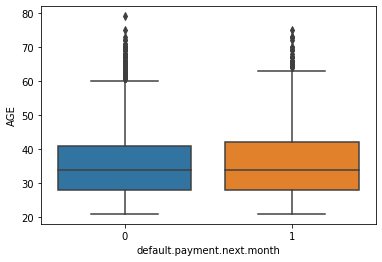

In [8]:
## Boxplot showing distributions of train-set
ax = sns.boxplot(x="default.payment.next.month", y="AGE", data=train)

In [9]:
## Run a t-test to compare if the test set has a relationship age and our target variable

ttest_ind(test[test['default.payment.next.month'] == 1]['AGE'],test[test['default.payment.next.month'] == 0]['AGE'])

Ttest_indResult(statistic=0.8666989760818128, pvalue=0.38613007689838164)

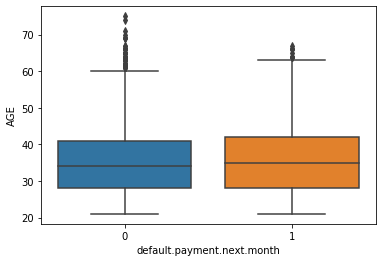

In [10]:
## Boxplot showing distributions of train-set
ax = sns.boxplot(x="default.payment.next.month", y="AGE", data=test)

Store label in y_train and y_test and drop ID columns

In [11]:
y_train = train['default.payment.next.month']
y_test = test['default.payment.next.month']
train = train.drop('default.payment.next.month', axis =1)
test = test.drop('default.payment.next.month', axis =1)
train = train.drop('ID', axis =1)
test = test.drop('ID', axis =1)

In [12]:
train.head()

,SEX = male,EDUCATION = university,EDUCATION = graduate school,EDUCATION = high school,EDUCATION = others,EDUCATION = 0,MARRIAGE = married,MARRIAGE = single,MARRIAGE = 0,LIMIT_BAL,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-1,1,0,0,0,0,1,0,0,50000.0,...,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
1,1,1,0,0,0,0,1,0,0,50000.0,...,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0
2,-1,1,0,0,0,0,0,1,0,100000.0,...,601.0,221.0,-159.0,567.0,380.0,601.0,0.0,581.0,1687.0,1542.0
3,-1,0,0,1,0,0,1,0,0,140000.0,...,12108.0,12211.0,11793.0,3719.0,3329.0,0.0,432.0,1000.0,1000.0,1000.0
4,1,0,0,1,0,0,0,1,0,20000.0,...,0.0,0.0,13007.0,13912.0,0.0,0.0,0.0,13007.0,1122.0,0.0


In [13]:
test[test['AGE'] >65]

,SEX = male,EDUCATION = university,EDUCATION = graduate school,EDUCATION = high school,EDUCATION = others,EDUCATION = 0,MARRIAGE = married,MARRIAGE = single,MARRIAGE = 0,LIMIT_BAL,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
312,-1,1,0,0,0,0,1,0,0,30000.0,...,27737.0,29499.0,30124.0,26855.0,0.0,1500.0,2182.0,1200.0,0.0,2302.0
598,1,0,0,1,0,0,1,0,0,580000.0,...,471175.0,486776.0,503914.0,527711.0,25704.0,9464.0,25065.0,25703.0,33000.0,215.0
635,1,0,1,0,0,0,1,0,0,250000.0,...,159849.0,145461.0,141487.0,147705.0,6243.0,5446.0,4721.0,4385.0,7805.0,200.0
646,1,1,0,0,0,0,1,0,0,160000.0,...,70848.0,71739.0,73090.0,74490.0,3400.0,3000.0,2600.0,2600.0,2700.0,2800.0
1081,1,0,0,1,0,0,0,1,0,210000.0,...,139411.0,138991.0,140886.0,143721.0,6510.0,6450.0,5103.0,5500.0,5307.0,5011.0
2212,-1,0,1,0,0,0,1,0,0,310000.0,...,220421.0,224801.0,229520.0,234145.0,8874.0,7984.0,8029.0,8324.0,8435.0,8552.0
2642,-1,1,0,0,0,0,1,0,0,300000.0,...,200.0,22935.0,16858.0,0.0,200.0,0.0,22935.0,0.0,0.0,0.0
2807,-1,0,0,1,0,0,0,1,0,100000.0,...,85103.0,86802.0,88912.0,90400.0,3035.0,3100.0,3100.0,3500.0,3500.0,7100.0
3976,-1,1,0,0,0,0,1,0,0,200000.0,...,102998.0,105090.0,107718.0,88964.0,4000.0,3800.0,3802.0,4363.0,3500.0,3303.0
4096,-1,1,0,0,0,0,1,0,0,500000.0,...,2988.0,11645.0,13237.0,303512.0,1755.0,2988.0,11645.0,13237.0,303512.0,0.0


Convert the datasets into files suitable for XGBoost modeling

In [14]:
dtrain = xgb.DMatrix(data = train, label=y_train)
dtest = xgb.DMatrix(data = test, label=y_test)
## Define paremeters to be used in XGboost
param = {'eta':0.1,
         'objective':'reg:logistic', 'eval_metr': 'AUC'}
## Train the model with all variables
xgb_model = xgb.train(param, dtrain, num_boost_round=100)
## Store the predictions back at the original test set
#test['y_hat_with_bias'] = xgb_model.predict(dtest)

[21:11:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[21:11:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[21:11:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[21:11:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[21:11:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[21:11:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[21:11:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prun

[21:11:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[21:11:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[21:11:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[21:11:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:11:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[21:11:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[21:11:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

XGBoost allows us to view variable interactions through Shapley Additive Explanation. By setting pred_interaction to True the output of the model becomes the SHAP values instead of predicted classes or probabilities.


In [15]:
feature_names = dtest.feature_names
interactions = xgb_model.predict(dtest, pred_interactions=True)
## Lets view the interactions for the first observation
pd.DataFrame(interactions[0],
             index = feature_names + ['intercept'],
             columns= feature_names + ['intercept'])

,SEX = male,EDUCATION = university,EDUCATION = graduate school,EDUCATION = high school,EDUCATION = others,EDUCATION = 0,MARRIAGE = married,MARRIAGE = single,MARRIAGE = 0,LIMIT_BAL,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,intercept
SEX = male,-2.133396e-02,-0.000198,-9.302005e-05,-1.531788e-04,1.968272e-05,-2.153010e-07,-0.000417,-0.003938,-1.190347e-07,0.000333,...,-4.477669e-03,0.000684,1.627326e-03,-0.003386,-4.233308e-04,0.000420,-5.778134e-03,6.774275e-03,2.060145e-03,0.000000
EDUCATION = university,-1.981547e-04,0.013458,-9.584750e-06,1.212719e-03,2.573332e-06,0.000000e+00,0.000355,-0.000005,1.009728e-06,0.000064,...,-5.020574e-05,-0.001139,2.877004e-04,0.001348,1.332834e-04,-0.002378,-2.151981e-03,-2.193265e-05,1.202840e-04,0.000000
EDUCATION = graduate school,-9.302143e-05,-0.000010,-6.347062e-03,1.163371e-04,-2.480811e-07,0.000000e+00,0.003073,-0.000310,-8.370262e-08,-0.000563,...,2.612472e-04,0.000150,1.657866e-04,0.000767,-9.411424e-04,0.000070,2.756506e-03,2.005257e-03,-6.638328e-03,0.000000
EDUCATION = high school,-1.531783e-04,0.001213,1.163372e-04,-2.994634e-03,-8.934876e-08,0.000000e+00,0.000324,0.000000,0.000000e+00,-0.000866,...,-9.465087e-04,0.000617,2.375208e-04,-0.000204,2.359375e-04,-0.001223,-1.307279e-04,2.055317e-04,8.093752e-04,0.000000
EDUCATION = others,1.968257e-05,0.000003,-2.480811e-07,-8.940697e-08,1.906548e-03,0.000000e+00,0.000000,0.000000,3.962195e-07,-0.001108,...,-6.863847e-06,0.000016,3.334135e-07,0.000090,3.022328e-05,0.000030,-1.975894e-05,4.905090e-05,1.862645e-07,0.000000
EDUCATION = 0,-2.160668e-07,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.714523e-05,0.000000,0.000000,0.000000e+00,0.000000,...,-1.285225e-07,0.000000,-1.676381e-08,0.000000,5.215406e-08,0.000000,0.000000e+00,-2.235174e-08,0.000000e+00,0.000000
MARRIAGE = married,-4.170723e-04,0.000355,3.072639e-03,3.236639e-04,0.000000e+00,0.000000e+00,0.026754,0.000000,0.000000e+00,0.002853,...,4.389882e-05,-0.000533,2.667338e-03,0.000857,-1.600113e-03,0.001240,1.009747e-03,4.041115e-03,-3.064595e-03,0.000000
MARRIAGE = single,-3.938364e-03,-0.000005,-3.102440e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.021715,0.000000e+00,0.001229,...,-6.897002e-05,0.000728,-3.681704e-04,-0.001515,1.317337e-04,0.001062,-2.512172e-03,-6.531551e-05,-3.604982e-04,0.000000
MARRIAGE = 0,-1.192093e-07,0.000001,-8.371717e-08,0.000000e+00,3.961613e-07,0.000000e+00,0.000000,0.000000,9.798619e-04,0.000009,...,-1.853332e-06,-0.000002,-1.277775e-06,0.000001,1.661479e-06,0.000008,-1.639128e-07,2.048910e-06,5.044043e-06,0.000000
LIMIT_BAL,3.333166e-04,0.000064,-5.630165e-04,-8.657125e-04,-1.108384e-03,0.000000e+00,0.002853,0.001229,8.746050e-06,0.273365,...,6.767677e-03,0.012506,-4.766643e-03,0.005876,7.885620e-03,-0.013863,7.924497e-03,3.840644e-03,5.044954e-03,0.000000


The sum of the interactions correspond to the log odds of the prediction. To derive the prediction, we need to use the log-link function and inverse the relationship

x/ (1+x)

In [16]:
shap_values = interactions.sum(axis=1)

In [17]:
### Because the sum of all the interactions for any observation corresponds to the log odds of the prediction, we have to transform it using np.exp
a = np.exp(interactions.sum(axis = 1).sum(axis = 1))
## From the log odds we can calculate the probability
base_prediction = a/ (1+a)

base_prediction_binary = np.where(base_prediction > 0.5, 1, 0)

In [18]:
base_prediction_binary = np.where(base_prediction > 0.5, 1, 0)

In [19]:
shap.force_plot(shap_values[7571][-1], shap_values[7571,:-1], test.iloc[7571,:])

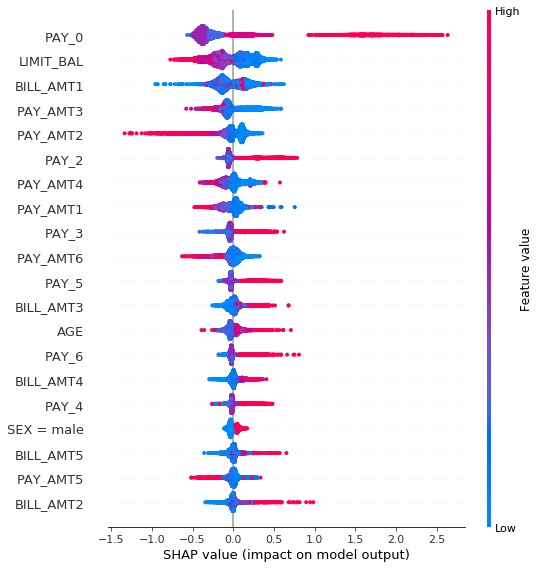

In [20]:
shap.summary_plot(shap_values[:,0:-1],test)

In [21]:
test_base = test
test_base['base_prediction'] = base_prediction_binary

In [22]:
## Create a contingency table to set it up for chi-square test
contingency_table = pd.crosstab(
    test_base['SEX = male'],
    test_base['base_prediction'],
    margins = True
)
## Calculate f_obs

f_obs = np.array([contingency_table.iloc[0][:].values,
                  contingency_table.iloc[1][:].values])

The Chi-Square test for male has a p value of less than 0.05, and as such we cannot reject the null hypotheses and we conclude that the prediction and sex variables are dependent.

In [23]:
## Calculate Chi-Square
stats.chi2_contingency(f_obs)[0:3]

(9.321988729518319, 0.009457053963589035, 2)

## Compliant Model

To reduce any discrimatory impact, we can change the interaction values for specific columns to zero as such negating the impact these values have on the prediction
The basis for SHAP is game theory where each variable "contributes" to the ending predicting. By not allowing certain variables input to count after the model has been developed, we are eliminating the impact of those varibles on the prediction


In [24]:
## Define what variables we want to remove the impact of
bias_var = np.array(['SEX = male'])
## Find the index of those variables
bias_idx = np.argwhere(np.isin(np.array(test.columns), bias_var))[0]
## Set the interaction values to zero
interactions[:, bias_idx, :] = 0
interactions[:, :, bias_idx] = 0


In [25]:
## Define what variables we want to remove the impact of
bias_var = np.array(['AGE'])
## Find the index of those variables
bias_idx = np.argwhere(np.isin(np.array(test.columns), bias_var))[0]
## Set the interaction values to zero
interactions[:, bias_idx, :] = 0
interactions[:, :, bias_idx] = 0

In [26]:
shap_values = interactions.sum(axis=1)

In [29]:
shap.force_plot(shap_values[7571][-1], shap_values[7571,:-1], test.iloc[7571,:-1])

In [63]:
shap_values[7571][0:-1]

array([ 0.0000000e+00,  1.1302616e-02,  3.5150466e-03, -5.8513023e-03,
        1.4502975e-03,  2.8766108e-05,  1.4766214e-02,  2.8886624e-02,
        2.9954943e-04, -1.8135320e-01,  0.0000000e+00, -3.9397162e-01,
       -4.3309901e-02, -5.0213564e-02, -1.8513249e-02, -2.2756707e-02,
       -3.6055215e-02,  2.2615698e-01,  1.8976361e-02,  4.0431745e-02,
        1.6856176e-01,  4.4964597e-02,  4.9583290e-02, -8.8531673e-02,
       -9.4554320e-02, -1.7282480e-01, -1.8622920e-01, -3.1184088e-02,
       -7.5774692e-02], dtype=float32)

In [60]:
test.columns[0:-3]

Index(['SEX = male', 'EDUCATION = university', 'EDUCATION = graduate school',
       'EDUCATION = high school', 'EDUCATION = others', 'EDUCATION = 0',
       'MARRIAGE = married', 'MARRIAGE = single', 'MARRIAGE = 0', 'LIMIT_BAL',
       'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
       'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6'],
      dtype='object')

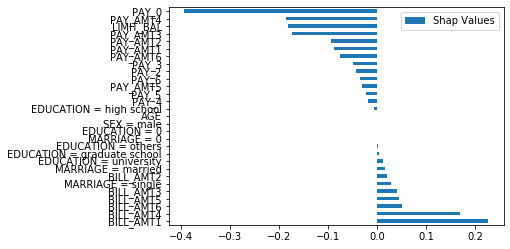

In [82]:
## Store explaination variables (SHAP) into a data frame so we can use them later for a print out.

dat1 = pd.DataFrame(data = shap_values[7571][0:-1], index =test.columns[0:-3])
dat1.columns = ['Shap Values']
dat1.sort_values('Shap Values',ascending = False).plot.barh()

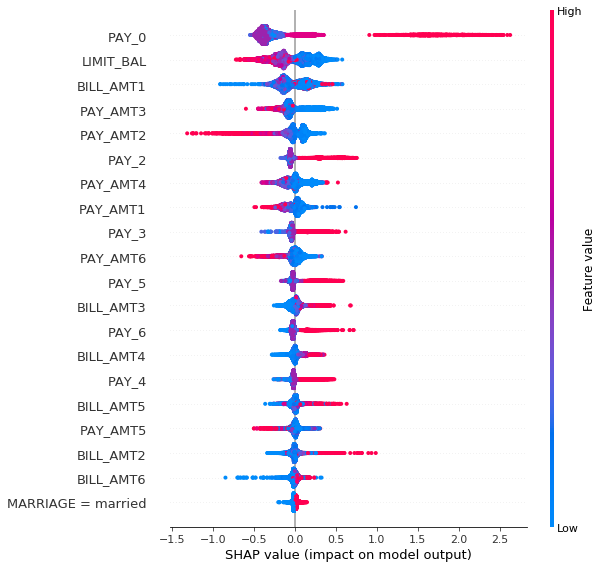

In [30]:
shap.summary_plot(shap_values[:,0:-1],test)

In [31]:
### Because the sum of all the interactions for any observation corresponds to the log odds of the prediction, we have to transform it using np.exp
a = np.exp(interactions.sum(axis = 1).sum(axis = 1))
## From the log odds we can calculate the probability
test['Probabilities'] = a/ (1+a)

In [32]:
## Assign any probability less than or equal to 0.5 to 0 class and and anything greater than to 1 and store in prediction variable
test['Prediction'] = np.where(test['Probabilities'] > 0.5, 1, 0)
  

In [33]:
auc = roc_auc_score(y_test, base_prediction)

print('Base AUC: %.2f' % auc)  

auc = roc_auc_score(y_test, test['Probabilities'])

print('Compliant AUC: %.2f' % auc)

Base AUC: 0.78
Compliant AUC: 0.78


In [38]:
test.corr()['Prediction']

SEX = male                     0.023336
EDUCATION = university         0.048271
EDUCATION = graduate school   -0.074883
EDUCATION = high school        0.066043
EDUCATION = others             0.012726
EDUCATION = 0                  0.028929
MARRIAGE = married             0.035337
MARRIAGE = single             -0.032886
MARRIAGE = 0                   0.013274
LIMIT_BAL                     -0.208471
AGE                            0.000486
PAY_0                          0.646143
PAY_2                          0.541035
PAY_3                          0.468483
PAY_4                          0.455172
PAY_5                          0.445158
PAY_6                          0.409513
BILL_AMT1                      0.029811
BILL_AMT2                      0.042435
BILL_AMT3                      0.044398
BILL_AMT4                      0.052330
BILL_AMT5                      0.064499
BILL_AMT6                      0.062445
PAY_AMT1                      -0.066314
PAY_AMT2                      -0.049854


In [35]:
## Create a contingency table to set it up for chi-square test
contingency_table = pd.crosstab(
    test['SEX = male'],
    test['Prediction'],
    margins = True
)
## Calculate f_obs
f_obs = np.array([contingency_table.iloc[0][:].values,
                  contingency_table.iloc[1][:].values])

Chi- Square P-value is now larger than 0.05 and as such we reject the null hypothesis that there is a relationship between the variables

In [36]:
## Calculate Chi-Square
stats.chi2_contingency(f_obs)[0:3]

(4.901214072529886, 0.08624121905900921, 2)

T-test p-value is larger than 0.05 and as such we reject the null hypotheses that the variables are related

In [37]:
ttest_ind(test[test['Prediction'] == 1]['AGE'],test[test['Prediction'] == 0]['AGE'])

Ttest_indResult(statistic=0.046123717552859836, pvalue=0.9632126658089628)